In [1]:
import numpy as np
from numpy.linalg import *

import math

from scipy.integrate import *
from scipy.signal import *

import matplotlib.pyplot as plt

Chariot Model
==============

We consider a mobile robot of "chariot" type, evolving in the plane.

  - From above, its frame appears to be a disk of diameter $D$. 
  
  - It has two fixed wheels (their orientation with respect to the frame does not change; there is no need for a steering wheel!). They are parallel and located at opposite ends of the frame (hence separated by a distance of $D$) ; these wheels have the common radius $R$.

  - The robot is symmetric with respect to the axis that joins the two wheels. For convenience, a green sticker is attached at the boundary of the frame on one side of this axis, on the robot axis of symmetry ; this side will is called the "front" of the robot, the point itself is called the "nose" of the robot. When we talk about the "left wheel" or the "right wheel", we assume that we are looking towards the front of the robot.

We will denote 

  - $(x, y)$ the coordinates of the wheel axis in the orthonormal and direct frame $(0, e_x, e_y)$ of the plane.
  
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the robot faces the right ($e_x$) and $\theta = \pi/2$ when he faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the robot moves forward.

### Parameter Definition


From now on, we assume that the frame diameter is $D = 1 \mbox{ m}$ and the wheel radius is $R = 10 \mbox{ cm}$.

🧩 Define the corresponding Python variables `D` and `R` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
D = 1
R = 0.1

### Graphical Representation

🧩 Implement a function `draw_robot` with arguments `x`, `y` and `theta` that draws the robot in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Represent the robot frame as a circle, the wheels as lines and the nose as an orange point.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

🧩 Represent the robot in when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, -\pi), (-4, 4, -\pi), (-8, 4, -\pi)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [8]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    plt.figure(figsize=figsize)
    axes = plt.gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    plt.xticks(np.arange(xmin, xmax+1, 1))
    plt.yticks(np.arange(ymin, ymax+1, 1))
    plt.grid(True)
    plt.plot([xmin, xmax], [0, 0],linewidth=4, linestyle="-", color="grey")
    plt.plot([0, 0], [ymin, ymax],linewidth=4, linestyle="-", color="grey")

In [9]:
def draw_robot(a):
    maxX = max(a, key=lambda x:x['x'])["x"]+D
    minX = min(a, key=lambda x:x['x'])["x"]-D
    maxY = max(a, key=lambda x:x['y'])["y"]+D
    minY = min(a, key=lambda x:x['y'])["y"]-D
    draw_arena(minX, maxX, minY, maxY)
    for i in a:

        x0=i["x"]
        y0=i["y"]

        tetha=i["angle"]

        xr0=[np.cos(tetha)*D/2+x0] 
        yr0=[np.sin(tetha)*D/2+y0]

        xl0=[-np.cos(tetha)*D/2+x0] 
        yl0=[-np.sin(tetha)*D/2+y0]

        xr1=[np.cos(tetha)*D/2+np.sin(tetha)*R+x0] 
        yr1=[np.sin(tetha)*D/2-np.cos(tetha)*R+y0]

        xr2=[np.cos(tetha)*D/2-np.sin(tetha)*R+x0] 
        yr2=[np.sin(tetha)*D/2+np.cos(tetha)*R+y0]


        xl1=[-np.cos(tetha)*D/2-np.sin(tetha)*R+x0] 
        yl1=[-np.sin(tetha)*D/2+np.cos(tetha)*R+y0]

        xl2=[-np.cos(tetha)*D/2+np.sin(tetha)*R+x0] 
        yl2=[-np.sin(tetha)*D/2-np.cos(tetha)*R+y0]

        l=[xl1+xl2,yl1+yl2]

        plt.plot(x0,y0, color = 'black', marker = 'o')

        plt.gca().annotate("("+str(x0)+" ; "+str(y0)+")", xy=(x0+D/2, y0+D/2), xycoords='data', fontsize=10)

        #draw a circle
        angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
        xs = D/2*np.cos(angles)+x0
        ys = D/2*np.sin(angles)+y0
        plt.plot(xs, ys, color = 'green')


        ynose=[np.cos(tetha)*D/2+y0]
        xnose=[-1*np.sin(tetha)*D/2+x0]

        plt.plot(xnose, ynose,color = 'purple', marker = 'o')
        
        plt.plot(xl1+xl2,yl1+yl2,color = 'red',linewidth=5)
        plt.plot(xl0,yl0,color = 'red', marker = 'o')

        plt.plot(xr1+xr2,yr1+yr2,color = 'blue',linewidth=5)
        plt.plot(xr0,yr0, color = 'blue', marker = 'o')
    
    plt.gca().set_aspect('equal')
    plt.show()

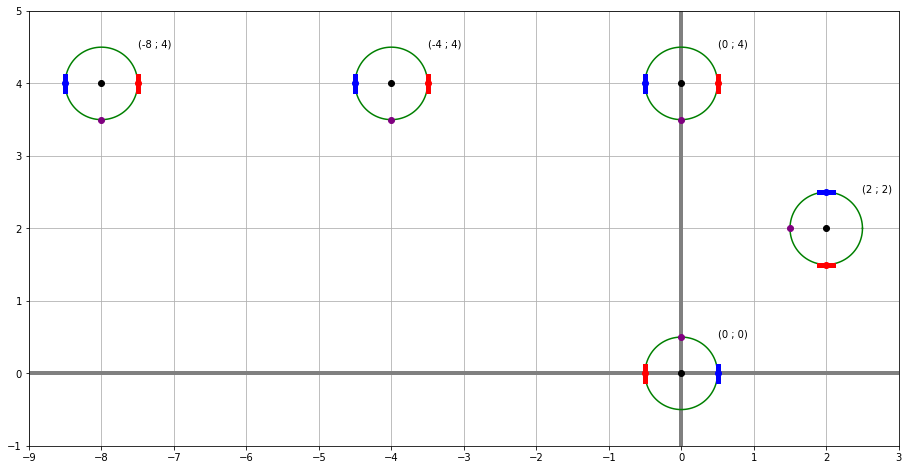

In [10]:
test = [
 {"x": 0, "y": 0, "angle": 0},
 {"x": 2, "y": 2, "angle": math.pi/2},
 {"x": 0, "y": 4, "angle": -math.pi},
 {"x": -4, "y": 4, "angle": -math.pi},
 {"x": -8, "y": 4, "angle": -math.pi},
]
draw_robot(test)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the robot).
We also assume that the chariot wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer:**

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer:**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer:**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [ ]:
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$, $(x,y,\theta)$ (and  -- implicitly -- the inputs $\omega$ computed by the function `omega`).

In [ ]:
def fun(t, xytheta):
    pass

### Simulation Setup

🧩 Simulate the robot dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = 7.5 \pi$ and $\omega_r = 12.5 \pi$.
(Compute the dense outputs.)
   

In [ ]:
pass

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

In [ ]:
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

In [ ]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer:**

🧩 Do your experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [ ]:
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $1e-5$ for each variable.

In [ ]:
pass